# APP

In [1]:
import pickle
from PIL import Image
import numpy as np
from pathlib import Path
from epb_detection_system import preprocess_epb_image, EPBRecognitionSystem, TwoDPCA

In [2]:
# 1. Carrega o modelo
print("📦 Carregando modelo treinado...")
with open('models/epb_recognition_model.pkl', 'rb') as f:
    model_data = pickle.load(f)

system = model_data['system']
target_size = model_data['target_size']
print("   ✓ Modelo carregado com sucesso!\n")

# 2. Processa todas as imagens do diretório img-teste
img_folder = Path('img-teste')
image_files = sorted(list(img_folder.glob('*.png')) + list(img_folder.glob('*.jpg')) + list(img_folder.glob('*.jpeg')))

if len(image_files) == 0:
    print("⚠️  Nenhuma imagem encontrada no diretório 'img-teste'")
else:
    print("="*70)
    print(f"🔍 PREDIÇÕES PARA {len(image_files)} IMAGENS")
    print("="*70 + "\n")
    
    for img_path in image_files:
        try:
            # Carrega e processa imagem
            img = Image.open(img_path).convert('L')
            img = np.array(img.resize(target_size))
            img = preprocess_epb_image(img)
            
            # Faz predição
            prob = system.predict_proba(img.reshape(1, *img.shape))[0]
            pred = system.predict(img.reshape(1, *img.shape))[0]
            
            # Exibe resultado
            print(f"📸 {img_path.name}")
            print(f"   EPB detectada: {'SIM' if pred == 1 else 'NÃO'}")
            print(f"   Probabilidade: {prob[1]*100:.2f}%")
            print()
            
        except Exception as e:
            print(f"❌ {img_path.name}")
            print(f"   Erro ao processar: {str(e)}")
            print()
    
    print("="*70)
    print("✅ PROCESSAMENTO CONCLUÍDO")
    print("="*70)

📦 Carregando modelo treinado...
   ✓ Modelo carregado com sucesso!

🔍 PREDIÇÕES PARA 8 IMAGENS

📸 ARA_O6_ARA_20250914_015414_1280.png
   EPB detectada: SIM
   Probabilidade: 99.89%

📸 BJL_O6_BJL_20250722_224024_1280.png
   EPB detectada: NÃO
   Probabilidade: 0.11%

📸 BJL_O6_BJL_20250723_004106_1280.png
   EPB detectada: NÃO
   Probabilidade: 0.09%

📸 BJL_O6_BJL_20250723_040936_1280.png
   EPB detectada: NÃO
   Probabilidade: 0.24%

📸 CA_O6_CA_20251022_224714_1280.png
   EPB detectada: SIM
   Probabilidade: 99.90%

📸 CP_O6_CP_20240209_002451_1280.png
   EPB detectada: SIM
   Probabilidade: 99.57%

📸 CP_O6_CP_20240815_070143_1280.png
   EPB detectada: NÃO
   Probabilidade: 44.75%

📸 STR_O6_STR_20231112_015212_1280.png
   EPB detectada: SIM
   Probabilidade: 50.80%

✅ PROCESSAMENTO CONCLUÍDO


🔬 ANÁLISE DETALHADA DE FEATURES


Analisando: BJL_O6_BJL_20250722_224024_1280.png

🔍 INTERPRETAÇÃO DAS FEATURES

📸 Imagem: BJL_O6_BJL_20250722_224024_1280.png
   • Classe real: Sem EPB
   • Predição: Sem EPB
   • Probabilidade EPB: 0.11%
   • Confiança: Alta

📊 Regiões mais importantes (pixels críticos):
   • Superior Esquerdo: 187 pixels (45.6%)
   • Superior Direito: 88 pixels (21.5%)
   • Inferior Esquerdo: 77 pixels (18.8%)
   • Inferior Direito: 58 pixels (14.1%)

💡 Interpretação:
   ✓ O modelo NÃO detectou padrões de EPB:
     - Distribuição uniforme de plasma
     - Ausência de estruturas irregulares
     - Características de ionosfera quieta


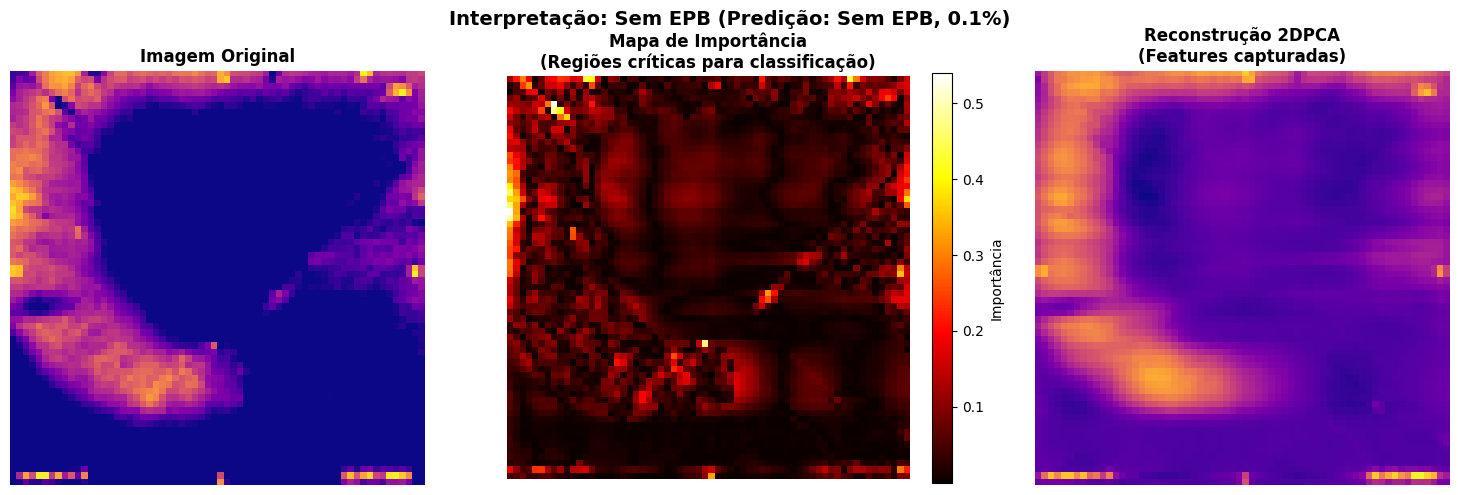


✓ Análise concluída para BJL_O6_BJL_20250722_224024_1280.png


Analisando: CP_O6_CP_20240815_070143_1280.png

🔍 INTERPRETAÇÃO DAS FEATURES

📸 Imagem: CP_O6_CP_20240815_070143_1280.png
   • Classe real: Sem EPB
   • Predição: Sem EPB
   • Probabilidade EPB: 44.75%
   • Confiança: Baixa

📊 Regiões mais importantes (pixels críticos):
   • Inferior Esquerdo: 228 pixels (55.6%)
   • Superior Esquerdo: 128 pixels (31.2%)
   • Superior Direito: 44 pixels (10.7%)
   • Inferior Direito: 10 pixels (2.4%)

💡 Interpretação:
   ✓ O modelo NÃO detectou padrões de EPB:
     - Distribuição uniforme de plasma
     - Ausência de estruturas irregulares
     - Características de ionosfera quieta


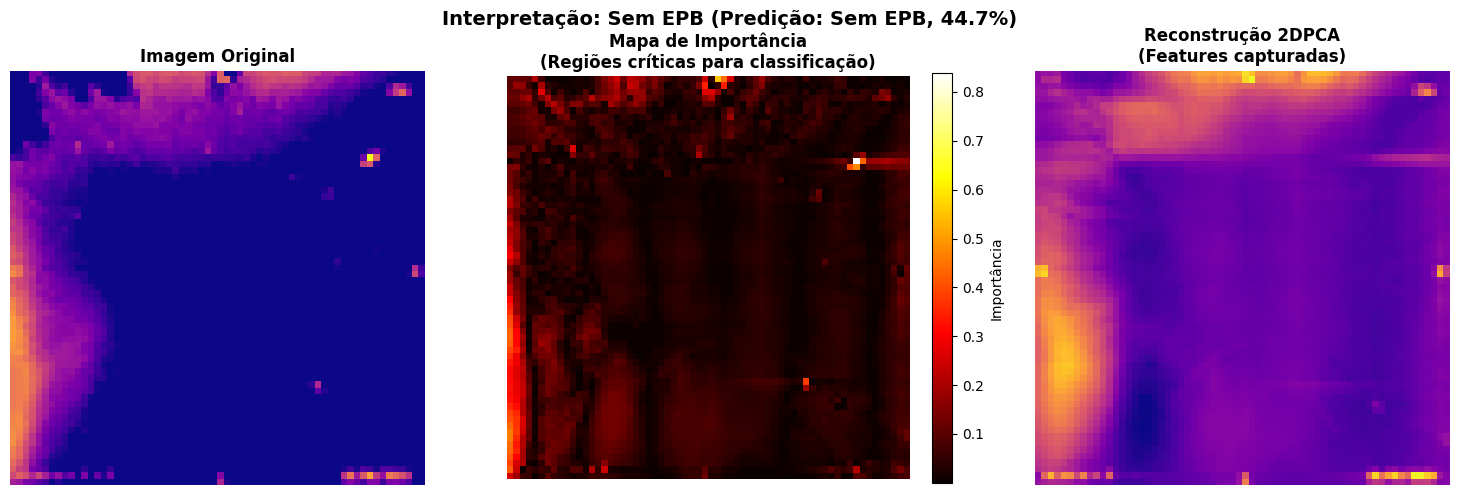


✓ Análise concluída para CP_O6_CP_20240815_070143_1280.png


Analisando: CA_O6_CA_20251022_224714_1280.png

🔍 INTERPRETAÇÃO DAS FEATURES

📸 Imagem: CA_O6_CA_20251022_224714_1280.png
   • Classe real: EPB
   • Predição: EPB
   • Probabilidade EPB: 99.90%
   • Confiança: Alta

📊 Regiões mais importantes (pixels críticos):
   • Inferior Direito: 174 pixels (42.4%)
   • Superior Direito: 153 pixels (37.3%)
   • Inferior Esquerdo: 73 pixels (17.8%)
   • Superior Esquerdo: 10 pixels (2.4%)

💡 Interpretação:
   ✓ O modelo identificou padrões característicos de EPB:
     - Estruturas verticais/irregulares
     - Deplecções localizadas de plasma
     - Distribuição espacial típica de bolhas


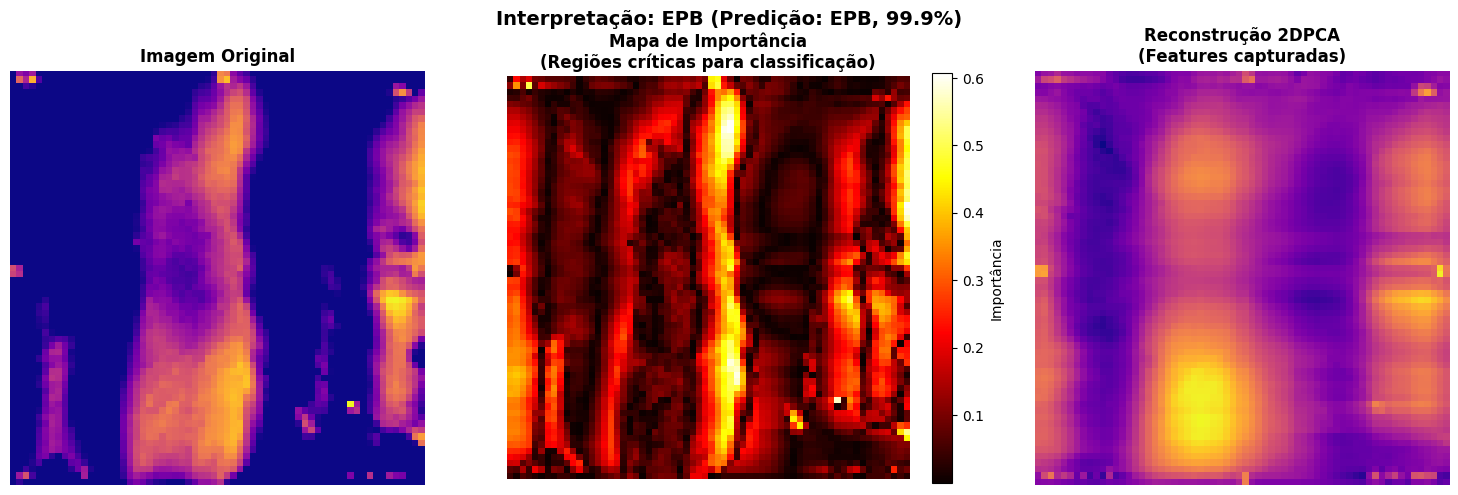


✓ Análise concluída para CA_O6_CA_20251022_224714_1280.png


✅ ANÁLISE DETALHADA CONCLUÍDA


In [4]:
from epb_detection_system import explain_feature_importance
import matplotlib.pyplot as plt

# Imagens específicas para análise detalhada
images = [
    'img-teste/BJL_O6_BJL_20250722_224024_1280.png',
    'img-teste/CP_O6_CP_20240815_070143_1280.png',
    'img-teste/CA_O6_CA_20251022_224714_1280.png'
]

print("="*70)
print("🔬 ANÁLISE DETALHADA DE FEATURES")
print("="*70 + "\n")

for img_path_str in images:
    img_path = Path(img_path_str)
    
    if not img_path.exists():
        print(f"⚠️  Arquivo não encontrado: {img_path}")
        print()
        continue
    
    try:
        print(f"\n{'='*70}")
        print(f"Analisando: {img_path.name}")
        print(f"{'='*70}")
        
        # Carrega e processa imagem
        img = Image.open(img_path).convert('L')
        img_original = np.array(img.resize(target_size))
        img_processed = preprocess_epb_image(img_original.copy())
        
        # Faz predição para obter o label predito
        pred = system.predict(img_processed.reshape(1, *img_processed.shape))[0]
        
        # Chama explain_feature_importance
        # Usa pred como y_sample (classe predita) para análise
        importance_map = explain_feature_importance(
            system=system,
            X_sample=img_processed,
            y_sample=pred,  # Usa predição como "classe real" para análise
            filename=img_path.name
        )
        
        print(f"\n✓ Análise concluída para {img_path.name}\n")
        
    except Exception as e:
        print(f"\n❌ Erro ao analisar {img_path.name}:")
        print(f"   {str(e)}")
        import traceback
        traceback.print_exc()
        print()

print("\n" + "="*70)
print("✅ ANÁLISE DETALHADA CONCLUÍDA")
print("="*70)